# 성능 최적화 종합실습 : Car seat sales
유아용 카시트 매출액을 예측해 봅시다.

* 카시트에 대해서 지역 매장 별 매출액을 예측하고자 합니다.

![](https://cdn.images.express.co.uk/img/dynamic/24/590x/child-car-seat-986556.jpg?r=1532946857754)

## 1.환경준비

### (1) Import

In [1]:
#라이브러리들을 불러오자.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 전처리
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 모델링
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import * 

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import warnings
warnings.filterwarnings(action='ignore')

### (2) 함수 생성

* 선형회귀용 전진선택법

In [2]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

def forward_stepwise_linear(x_train, y_train):

    # 변수목록, 선택된 변수 목록, 단계별 모델과 AIC 저장소 정의
    features = list(x_train)
    selected = []
    step_df = pd.DataFrame({ 'step':[], 'feature':[],'aic':[]})

    # 
    for s in range(0, len(features)) :
        result =  { 'step':[], 'feature':[],'aic':[]}

        # 변수 목록에서 변수 한개씩 뽑아서 모델에 추가
        for f in features :
            vars = selected + [f]
            x_tr = x_train[vars]
            model = OLS(y_train, add_constant(x_tr)).fit(disp=False)
            result['step'].append(s+1)
            result['feature'].append(vars)
            result['aic'].append(model.aic)
        
        # 모델별 aic 집계
        temp = pd.DataFrame(result).sort_values('aic').reset_index(drop = True)

        # 만약 이전 aic보다 새로운 aic 가 크다면 멈추기
        if step_df['aic'].min() < temp['aic'].min() :
            break
        step_df = pd.concat([step_df, temp], axis = 0).reset_index(drop = True)

        # 선택된 변수 제거
        v = temp.loc[0,'feature'][s]
        features.remove(v)

        selected.append(v)
    
    # 선택된 변수와 step_df 결과 반환
    return selected, step_df

* 변수 중요도 그래프

In [3]:
def plot_feature_importance(importance, names):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df.reset_index(drop=True, inplace = True)

    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.grid()

    return fi_df

### (3) Data Loading

In [4]:
data_path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/Carseats.csv'
data = pd.read_csv(data_path)

**변수설명**
> * Sales - 각 지역 판매량(단위 : 1000개) <== Target
* CompPrice - 각 지역 경쟁사 가격
* Income - 각 지역 평균 소득수준(단위 : 1000달러)
* Advertising - 각 지역, 회사의 광고 예산(단위 : 1000달러)
* Population - 지역 인구수(단위 : 1000명)
* Price - 자사 지역별 판매가격
* ShelveLoc - 진열상태
* Age - 지역 인구의 평균 연령
* Education - 각 지역 교육수준 레벨
* Urban - 매장 도시 지역 여부
* US - 매장이 미국에 있는지 여부

## 2.데이터 이해

* 둘러보기

In [5]:
data.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


## 3.데이터 준비

### (1) 데이터 정리

In [6]:
data['Diff_Price'] = data['CompPrice'] - data['Price']
data.drop('CompPrice', axis = 1, inplace = True)

### (2) 데이터분할1 : x, y 나누기

In [7]:
# x와 y 분리
target = 'Sales'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

### (3) NA 조치

### (4) 가변수화

In [8]:
# 범주형(가변수화 대상) 변수 리스트(목록) 작성
dumm_var = ['ShelveLoc','Education','Urban','US']

# 리스트로 가변수화 수행. 
x = pd.get_dummies(x, columns = dumm_var, drop_first = True)
x.head()

,Income,Advertising,Population,Price,Age,Diff_Price,ShelveLoc_Good,ShelveLoc_Medium,Education_11,Education_12,Education_13,Education_14,Education_15,Education_16,Education_17,Education_18,Urban_Yes,US_Yes
0,73,11,276,120,42,18,0,0,0,0,0,0,0,0,1,0,1,1
1,48,16,260,83,65,28,1,0,0,0,0,0,0,0,0,0,1,1
2,35,10,269,80,59,33,0,1,0,1,0,0,0,0,0,0,1,1
3,100,4,466,97,55,20,0,1,0,0,0,1,0,0,0,0,1,1
4,64,3,340,128,38,13,0,0,0,0,1,0,0,0,0,0,1,0


### (5) 데이터분할2 : train : validation 나누기

In [9]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .3, random_state = 2022)

### (6) Scaling
KNN 알고리즘을 적용하기 위해서는 스케일링을 해야 합니다.

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_train_s = scaler.fit_transform(x_train)
x_val_s = scaler.transform(x_val)

## 4.모델링



### (1) 선형회귀

In [11]:
vars, result = forward_stepwise_linear(x_train, y_train)

In [12]:
vars

['Diff_Price',
 'ShelveLoc_Good',
 'ShelveLoc_Medium',
 'Advertising',
 'Age',
 'Income',
 'Education_15']

In [13]:
# 선택된 변수
lr_m1 = LinearRegression()
lr_m1.fit(x_train[vars], y_train)
p1 = lr_m1.predict(x_val[vars])

print('RMSE : ', mean_squared_error(y_val, p1, squared=False))
print('MAE  : ', mean_absolute_error(y_val, p1))
print('MAPE : ', mean_absolute_percentage_error(y_val, p1))

RMSE :  1.0208894840413911
MAE  :  0.8014365161361271
MAPE :  0.20785310360108078


In [14]:
# 전체 변수
lr_m2 = LinearRegression()
lr_m2.fit(x_train, y_train)
p2 = lr_m2.predict(x_val)

print('RMSE : ', mean_squared_error(y_val, p2, squared=False))
print('MAE  : ', mean_absolute_error(y_val, p2))
print('MAPE : ', mean_absolute_percentage_error(y_val, p2))

RMSE :  1.0417209287542317
MAE  :  0.8291702856537125
MAPE :  0.2173548759045311


### (2) KNN

In [15]:
# dictionary형태로 선언
params = { 'n_neighbors' : range(3,51,2), 'metric' : ['euclidean', 'manhattan']  }
params

{'n_neighbors': range(3, 51, 2), 'metric': ['euclidean', 'manhattan']}

In [16]:
# 기본모델
m = KNeighborsRegressor()

# Random Search 설정.
knn_m = GridSearchCV(m, params, cv=5)

In [17]:
# 학습 
knn_m.fit(x_train_s, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': range(3, 51, 2)})

In [18]:
# 최적의 파라미터
knn_m.best_params_

{'metric': 'manhattan', 'n_neighbors': 7}

In [19]:
# 그때의 성능
knn_m.best_score_

0.36940512788706253

In [20]:
# best 모델로 예측 및 평가
p3 = knn_m.predict(x_val_s)
print('RMSE : ', mean_squared_error(y_val, p3, squared=False))
print('MAE  : ', mean_absolute_error(y_val, p3))
print('MAPE : ', mean_absolute_percentage_error(y_val, p3))

RMSE :  2.284023958319367
MAE  :  1.8755238095238096
MAPE :  0.6961450106817675


In [21]:
result = pd.DataFrame(knn_m.cv_results_)

In [22]:
# 이 중에서 하이퍼파라미터 값에 따른 성능을 별도로 저장합시다.
temp = result.loc[:, ['param_metric', 'param_n_neighbors','mean_test_score']]
temp.head()

,param_metric,param_n_neighbors,mean_test_score
0,euclidean,3,0.222969
1,euclidean,5,0.275763
2,euclidean,7,0.308126
3,euclidean,9,0.284253
4,euclidean,11,0.306238


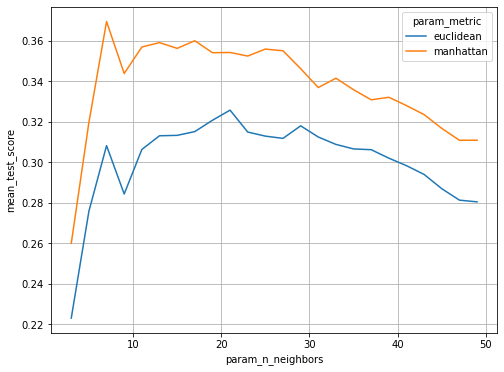

In [23]:
# 이를 차트로 그려봅시다.
plt.figure(figsize = (8,6))
sns.lineplot(x = 'param_n_neighbors', y = 'mean_test_score', data = temp, hue = 'param_metric')
plt.grid()
plt.show()

### (3) Decision Tree

In [24]:
# dictionary형태로 선언
params = {'max_depth' : range(2,11)}
params

{'max_depth': range(2, 11)}

In [25]:
# 기본모델
m = DecisionTreeRegressor()

# Random Search 설정.
dt_m = GridSearchCV(m, params, cv=5, scoring = 'neg_mean_absolute_error')

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [26]:
# 학습 
dt_m.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': range(2, 11)},
             scoring='neg_mean_absolute_error')

In [27]:
# 최적의 파라미터
dt_m.best_params_

{'max_depth': 5}

In [28]:
# 그때의 성능
dt_m.best_score_

-1.4419941327799322

In [29]:
# best 모델로 예측 및 평가
p4 = dt_m.predict(x_val)
print('RMSE : ', mean_squared_error(y_val, p4, squared=False))
print('MAE  : ', mean_absolute_error(y_val, p4))
print('MAPE : ', mean_absolute_percentage_error(y_val, p4))

RMSE :  1.7976537943025497
MAE  :  1.4922750082325078
MAPE :  0.5032440040138062


In [30]:
result = pd.DataFrame(dt_m.cv_results_)

In [31]:
# 이 중에서 하이퍼파라미터 값에 따른 성능을 별도로 저장합시다.
temp = result.loc[:, ['param_max_depth','mean_test_score']]
temp.head()

,param_max_depth,mean_test_score
0,2,-1.768513
1,3,-1.623477
2,4,-1.481657
3,5,-1.441994
4,6,-1.499044


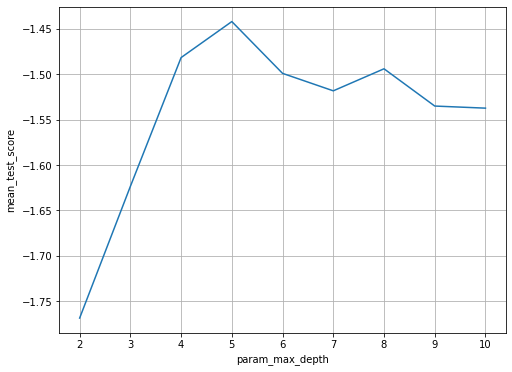

In [32]:
# 이를 차트로 그려봅시다.
plt.figure(figsize = (8,6))
sns.lineplot(x = 'param_max_depth', y = 'mean_test_score', data = temp)
plt.grid()
plt.show()

### (4) Random Forest

In [33]:
# dictionary형태로 선언
params = {'max_depth' : range(2,21)}
params

{'max_depth': range(2, 21)}

In [34]:
# 기본모델
m = RandomForestRegressor()

# Random Search 설정.
rf_m = GridSearchCV(m, params, cv=5)

In [35]:
# 학습
rf_m.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(2, 21)})

In [36]:
# 최적의 파라미터
rf_m.best_params_

{'max_depth': 20}

In [37]:
# 그때의 성능
rf_m.best_score_

0.731548557256397

In [38]:
# best 모델로 예측 및 평가
p5 = rf_m.predict(x_val)
print('RMSE : ', mean_squared_error(y_val, p5, squared=False))
print('MAE  : ', mean_absolute_error(y_val, p5))
print('MAPE : ', mean_absolute_percentage_error(y_val, p5))

RMSE :  1.3614762242078753
MAE  :  1.1140308333333333
MAPE :  0.3119755992115864


In [39]:
result = pd.DataFrame(rf_m.cv_results_)

In [40]:
# 이 중에서 하이퍼파라미터 값에 따른 성능을 별도로 저장합시다.
temp = result.loc[:, ['param_max_depth','mean_test_score']]
temp.head()

,param_max_depth,mean_test_score
0,2,0.487122
1,3,0.580762
2,4,0.655608
3,5,0.708340
4,6,0.714968


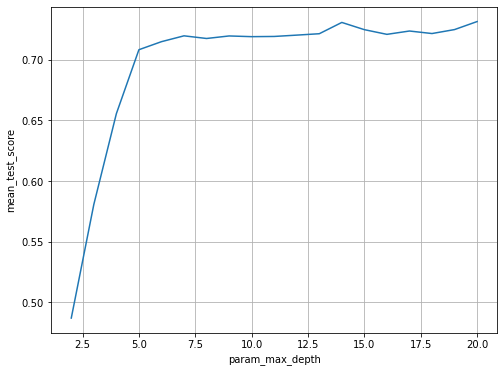

In [41]:
# 이를 차트로 그려봅시다.
plt.figure(figsize = (8,6))
sns.lineplot(x = 'param_max_depth', y = 'mean_test_score', data = temp)
plt.grid()
plt.show()

### (5) XGB

In [42]:
# dictionary형태로 선언
params = {'learning_rate' : np.linspace(0.01,0.2, 20), 'n_estimators':range(60,200,20), 'max_depth':[3,4,5,6]}
params

{'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
        0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ]),
 'n_estimators': range(60, 200, 20),
 'max_depth': [3, 4, 5, 6]}

In [43]:
# 기본모델
m = XGBRegressor(objective = 'reg:squarederror')

# Random Search 설정.
xgb_m = GridSearchCV(m, params, cv=5)

In [44]:
# 학습
xgb_m.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None, ...),
             param_grid={'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ]),
                         'max_depth': [3, 4, 5, 6],
                         'n_estimators': range(60, 200, 20)})

In [45]:
# 최적의 파라미터
xgb_m.best_params_

{'learning_rate': 0.08, 'max_depth': 3, 'n_estimators': 120}

In [46]:
# 그때의 성능
xgb_m.best_score_

0.7742082318377236

In [47]:
# best 모델로 예측 및 평가
p6 = xgb_m.predict(x_val)
print('RMSE : ', mean_squared_error(y_val, p6, squared=False))
print('MAE  : ', mean_absolute_error(y_val, p6))
print('MAPE : ', mean_absolute_percentage_error(y_val, p6))

RMSE :  1.2211076964862972
MAE  :  1.0004289759000142
MAPE :  0.3114429073992751


### (6) SVM

In [48]:
# dictionary형태로 선언
params = {'C' : np.linspace(0.01, 100, 50), 'gamma':[0.001,0.01,.1,1]}
params

{'C': array([1.00000000e-02, 2.05061224e+00, 4.09122449e+00, 6.13183673e+00,
        8.17244898e+00, 1.02130612e+01, 1.22536735e+01, 1.42942857e+01,
        1.63348980e+01, 1.83755102e+01, 2.04161224e+01, 2.24567347e+01,
        2.44973469e+01, 2.65379592e+01, 2.85785714e+01, 3.06191837e+01,
        3.26597959e+01, 3.47004082e+01, 3.67410204e+01, 3.87816327e+01,
        4.08222449e+01, 4.28628571e+01, 4.49034694e+01, 4.69440816e+01,
        4.89846939e+01, 5.10253061e+01, 5.30659184e+01, 5.51065306e+01,
        5.71471429e+01, 5.91877551e+01, 6.12283673e+01, 6.32689796e+01,
        6.53095918e+01, 6.73502041e+01, 6.93908163e+01, 7.14314286e+01,
        7.34720408e+01, 7.55126531e+01, 7.75532653e+01, 7.95938776e+01,
        8.16344898e+01, 8.36751020e+01, 8.57157143e+01, 8.77563265e+01,
        8.97969388e+01, 9.18375510e+01, 9.38781633e+01, 9.59187755e+01,
        9.79593878e+01, 1.00000000e+02]),
 'gamma': [0.001, 0.01, 0.1, 1]}

In [49]:
# 기본모델
m = SVR()

# Random Search 설정.
svm_m = GridSearchCV(m, params, cv=5)

In [50]:
# 학습
svm_m.fit(x_train_s, y_train)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': array([1.00000000e-02, 2.05061224e+00, 4.09122449e+00, 6.13183673e+00,
       8.17244898e+00, 1.02130612e+01, 1.22536735e+01, 1.42942857e+01,
       1.63348980e+01, 1.83755102e+01, 2.04161224e+01, 2.24567347e+01,
       2.44973469e+01, 2.65379592e+01, 2.85785714e+01, 3.06191837e+01,
       3.26597959e+01, 3.47004082e+01, 3.67410204e+01, 3.878163...
       5.71471429e+01, 5.91877551e+01, 6.12283673e+01, 6.32689796e+01,
       6.53095918e+01, 6.73502041e+01, 6.93908163e+01, 7.14314286e+01,
       7.34720408e+01, 7.55126531e+01, 7.75532653e+01, 7.95938776e+01,
       8.16344898e+01, 8.36751020e+01, 8.57157143e+01, 8.77563265e+01,
       8.97969388e+01, 9.18375510e+01, 9.38781633e+01, 9.59187755e+01,
       9.79593878e+01, 1.00000000e+02]),
                         'gamma': [0.001, 0.01, 0.1, 1]})

In [51]:
# 최적의 파라미터
svm_m.best_params_

{'C': 100.0, 'gamma': 0.01}

In [52]:
# 그때의 성능
svm_m.best_score_

0.8326708522670307

In [53]:
p7 = svm_m.predict(x_val_s)
print('RMSE : ', mean_squared_error(y_val, p7, squared=False))
print('MAE  : ', mean_absolute_error(y_val, p7))
print('MAPE : ', mean_absolute_percentage_error(y_val, p7))

RMSE :  1.098761900270489
MAE  :  0.874176513409451
MAPE :  0.2558053426776504


In [54]:
result = pd.DataFrame(svm_m.cv_results_)

In [55]:
# 이 중에서 하이퍼파라미터 값에 따른 성능을 별도로 저장합시다.
temp = result.loc[:, ['param_C','param_gamma','mean_test_score']]
temp['param_gamma'] = temp['param_gamma'].astype('str')
temp.head()

,param_C,param_gamma,mean_test_score
0,0.01,0.001,-0.014159
1,0.01,0.01,-0.012485
2,0.01,0.1,-0.001837
3,0.01,1,-0.006271
4,2.050612,0.001,0.021313


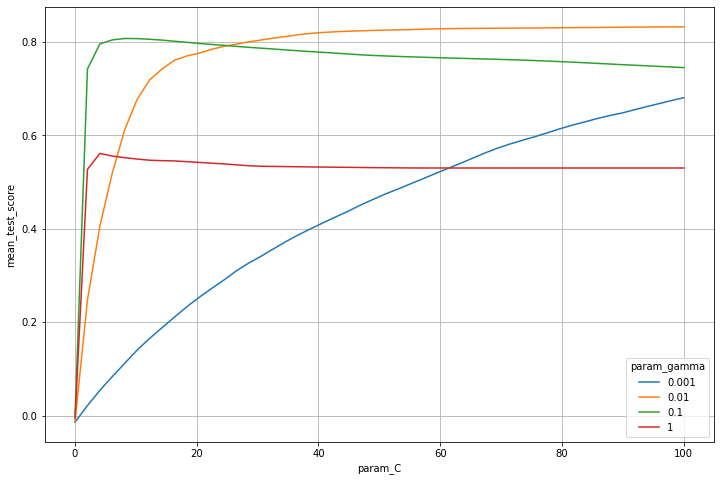

In [56]:
# 이를 차트로 그려봅시다.
plt.figure(figsize = (12,8))
sns.lineplot(x = 'param_C', y = 'mean_test_score', data = temp, hue = 'param_gamma')
plt.grid()
plt.show()

### (7) 성능비교

In [57]:
RMSE, MAE, MAPE = [],[],[]
model_desc = ['lr_selected', 'lr_all','knn','dt','rf','xgb','svm']
pred = [p1, p2, p3, p4, p5, p6,p7]

for i, p in enumerate(pred) :
    RMSE.append(mean_squared_error(y_val, p, squared=False))
    MAE.append(mean_absolute_error(y_val, p))
    MAPE.append(mean_absolute_percentage_error(y_val, p))

result = pd.DataFrame({'model_desc':model_desc,'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE})
result

,model_desc,RMSE,MAE,MAPE
0,lr_selected,1.020889,0.801437,0.207853
1,lr_all,1.041721,0.829170,0.217355
2,knn,2.284024,1.875524,0.696145
3,dt,1.797654,1.492275,0.503244
4,rf,1.361476,1.114031,0.311976
5,xgb,1.221108,1.000429,0.311443
6,svm,1.098762,0.874177,0.255805


In [58]:
n_est = range(10,300,10)
train_mae, val_mae = [],[]
for n in n_est :
    m = XGBRegressor(n_estimators = n) 
    m.fit(x_train, y_train)
    tr_p, va_p = m.predict(x_train), m.predict(x_val)
    train_mae.append(mean_absolute_error(y_train, tr_p))
    val_mae.append(mean_absolute_error(y_val, va_p))
    

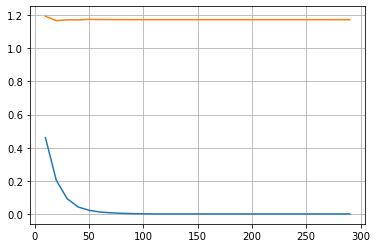

In [59]:
plt.plot(n_est,train_mae )
plt.plot(n_est,val_mae )
# plt.ylim(1.1,1.2)
plt.grid()
plt.show()